**Multiple Regression for sp500 Prediction Using Sector ETFs**
======

By Maxim Shen ...     Jul 12th 2016

In this example, we want to illustrate how we can predict SP500 index, given different sector ETF historical daily market data. 

We try to reduce independent dimensions to determine our best multiple regression model to achieve better prediction capability by reducing independents multicollinearity and possible overfitting, increasing model update efficiency


In [1]:
'''
In this example, we pick some ETF with relative less tracking errors 

IYK - consumer goods
VIS - industries
VPU - utilities
XLK - technology
PCF - finance
FENY - energy
FREL - real estate

'''

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model
import statsmodels.api as sm

path = 'csv/'
price = 'Adj Close'
fields = ['Date','Adj Close']

# load 8 independents and dependent data
colTitles = ['cust', 'idst', 'util', 'tech', 'fina', 'engy', 'rest', 'care']

cust = pd.read_csv(path + 'consumer_IYK.csv', usecols=fields, index_col='Date')
idst = pd.read_csv(path + 'industries_VIS.csv', usecols=fields, index_col='Date')
util = pd.read_csv(path + 'utilities_VPU.csv', usecols=fields, index_col='Date')
tech = pd.read_csv(path + 'tech_XLK.csv', usecols=fields, index_col='Date')
fina = pd.read_csv(path + 'finance_PGF.csv', usecols=fields, index_col='Date')
engy = pd.read_csv(path + 'energy_FENY.csv', usecols=fields, index_col='Date')
rest = pd.read_csv(path + 'realestate_FREL.csv', usecols=fields, index_col='Date')
care = pd.read_csv(path + 'healthcare_IHI.csv', usecols=fields, index_col='Date')

sp500 = pd.read_csv(path + 'sp500.csv', usecols=fields, low_memory=False, index_col='Date')  

# data includes 131 trading days between Jan 4th 2016 and Jul 11th 2016
print(cust.shape,idst.shape,util.shape,tech.shape,fina.shape,engy.shape,rest.shape,sp500.shape)

(131, 1) (131, 1) (131, 1) (131, 1) (131, 1) (131, 1) (131, 1) (131, 1)


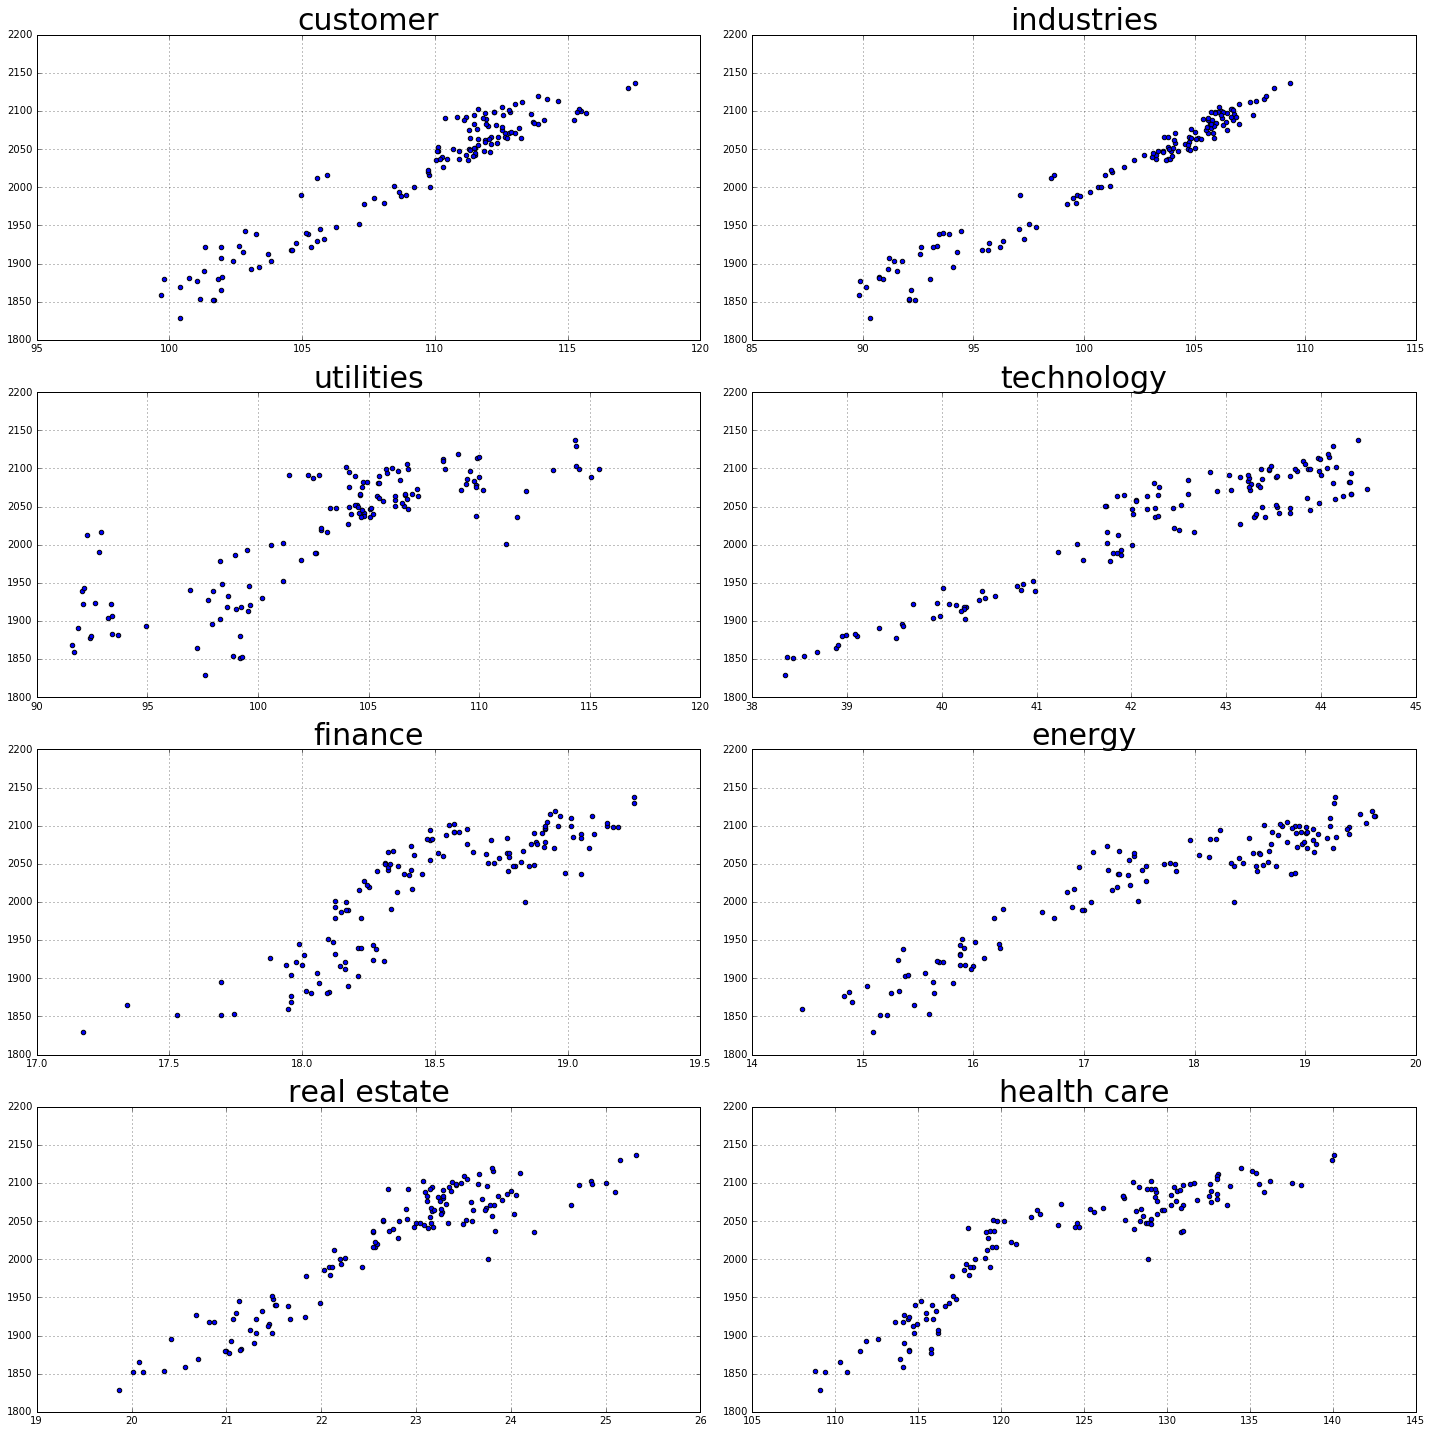

In [2]:
# Make scatter plots for all independents and dependent(SP500) pairs 
%matplotlib inline

fig = plt.figure(figsize=(20, 20))

sub1 = fig.add_subplot(421)
sub1.scatter(cust, sp500)
sub1.set_title('customer', fontsize=30)
sub1.grid(True)

sub2 = fig.add_subplot(422)
sub2.scatter(idst, sp500)
sub2.set_title('industries', fontsize=30)
sub2.grid(True)

sub3 = fig.add_subplot(423)
sub3.scatter(util, sp500)
sub3.set_title('utilities', fontsize=30)
sub3.grid(True)

sub4 = fig.add_subplot(424)
sub4.scatter(tech, sp500)
sub4.set_title('technology', fontsize=30)
sub4.grid(True)

sub5 = fig.add_subplot(425)
sub5.scatter(fina, sp500)
sub5.set_title('finance', fontsize=30)
sub5.grid(True)

sub6 = fig.add_subplot(426)
sub6.scatter(engy, sp500)
sub6.set_title('energy', fontsize=30)
sub6.grid(True)

sub7 = fig.add_subplot(427)
sub7.scatter(rest, sp500)
sub7.set_title('real estate', fontsize=30)
sub7.grid(True)

sub8 = fig.add_subplot(428)
sub8.scatter(care, sp500)
sub8.set_title('health care', fontsize=30)
sub8.grid(True)

fig.tight_layout()

**Observation:** 

1. All independent variables seem having certain linear correlation with SP500, 
2. except for lower range of utilities
3. Let's still keep 'utilities' independent in the model for now
4. Later, we will take out 'utilities' to improve the model prediction capability 

In [3]:
# Next, let's check all Adjusted R-squared scores for all pairs above
colTitles = ['cust', 'idst', 'util', 'tech', 'fina', 'engy', 'rest', 'care']
print('cust', sm.OLS(sp500, cust).fit().rsquared_adj)
print('idst', sm.OLS(sp500, idst).fit().rsquared_adj)
print('util', sm.OLS(sp500, util).fit().rsquared_adj)
print('tech', sm.OLS(sp500, tech).fit().rsquared_adj)
print('fina', sm.OLS(sp500, fina).fit().rsquared_adj)
print('engy', sm.OLS(sp500, engy).fit().rsquared_adj)
print('rest', sm.OLS(sp500, rest).fit().rsquared_adj)
print('care', sm.OLS(sp500, care).fit().rsquared_adj)

cust 0.999878271424
idst 0.999672708306
util 0.998866896615
tech 0.999823931866
fina 0.999471444364
engy 0.997757890206
rest 0.999478007237
care 0.998983909575


**Observation:** 

1. All pairs have pretty high adjusted r-squared values 
2. It is hard for us to take out any dimension at this stage

In [4]:
# Let's concatenate all data columns to make a whole dataframe
data = pd.concat([cust, idst, util, tech, fina, engy, rest, care], axis=1)
data.columns = colTitles
data.head()

,cust,idst,util,tech,fina,engy,rest,care
Date,,,,,,,,
2016-07-11,117.529999,109.309998,114.349998,44.389999,19.25,19.270000,25.320000,140.039993
2016-07-08,117.279999,108.570000,114.379997,44.130001,19.25,19.260000,25.150000,139.949997
2016-07-07,115.680000,106.459999,113.330002,43.450001,19.17,19.010000,24.719999,138.100006
2016-07-06,115.489998,106.180000,115.419998,43.450001,19.15,19.219999,25.000000,137.520004
2016-07-05,115.239998,105.599998,115.059998,43.150002,19.10,19.120001,25.100000,135.820007


In [5]:
# Correlation matrix for all independent variables
print(round(data.corr(),4))

        cust    idst    util    tech    fina    engy    rest    care
cust  1.0000  0.9701  0.9183  0.9178  0.8378  0.9270  0.9375  0.8985
idst  0.9701  1.0000  0.8540  0.9275  0.8125  0.9452  0.8920  0.8813
util  0.9183  0.8540  1.0000  0.7680  0.7917  0.8646  0.8711  0.8449
tech  0.9178  0.9275  0.7680  1.0000  0.7231  0.8231  0.8379  0.7827
fina  0.8378  0.8125  0.7917  0.7231  1.0000  0.8964  0.9318  0.9498
engy  0.9270  0.9452  0.8646  0.8231  0.8964  1.0000  0.9082  0.9431
rest  0.9375  0.8920  0.8711  0.8379  0.9318  0.9082  1.0000  0.9425
care  0.8985  0.8813  0.8449  0.7827  0.9498  0.9431  0.9425  1.0000


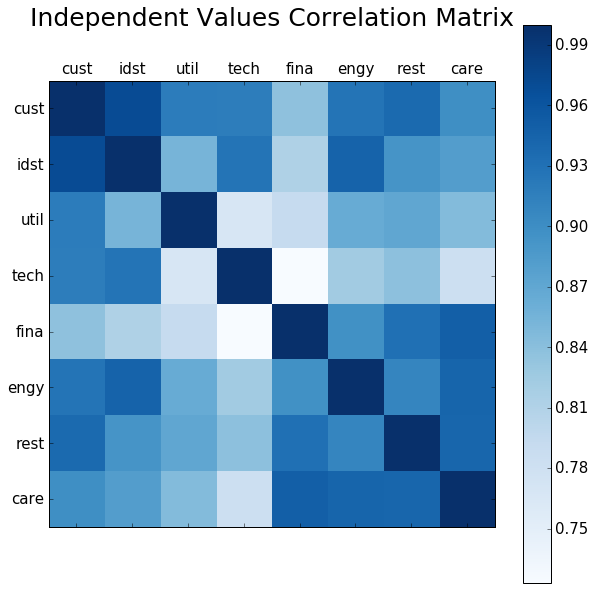

In [6]:
# Correlation matrix Heatmap
fig = plt.figure(figsize=(10, 10))

ax = fig.add_subplot(111)
ax.set_title('Independent Values Correlation Matrix\n', fontsize=25)

cax = ax.matshow(data.corr(),cmap=plt.cm.Blues)
cbar = fig.colorbar(cax)
cbar.set_label("",size=15)
cbar.ax.tick_params(labelsize=15) 

xText = ax.set_xticklabels(['']+colTitles, fontsize=15)
yText = ax.set_yticklabels(['']+colTitles, fontsize=15)

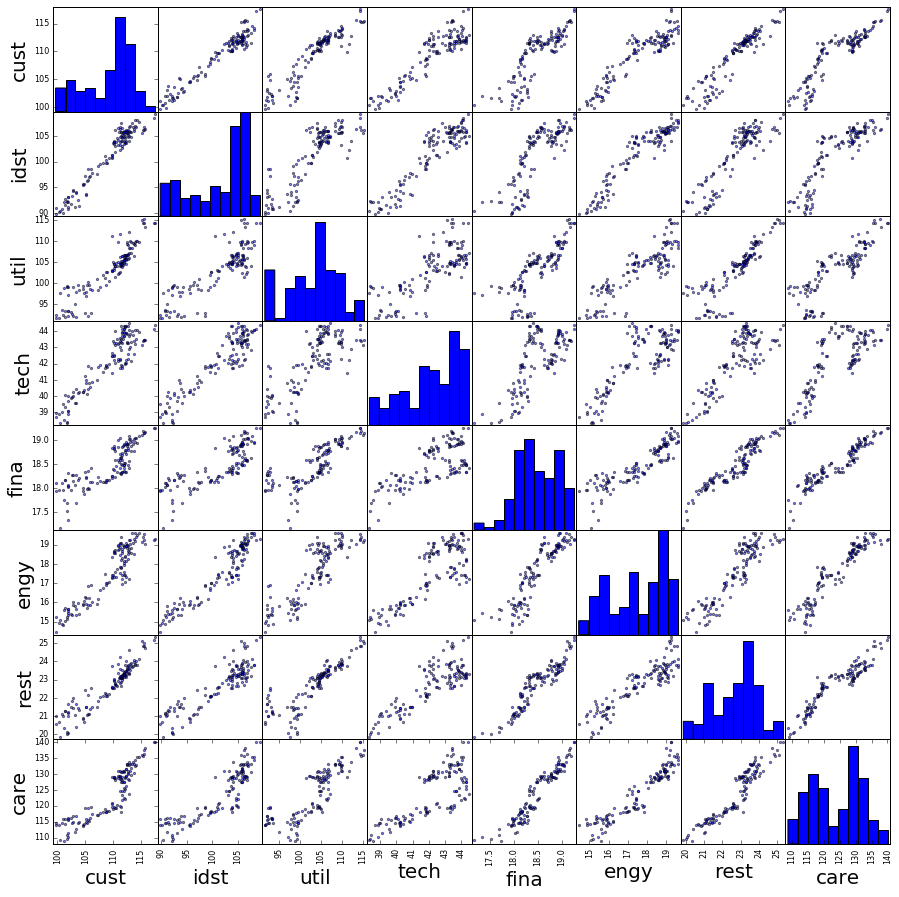

In [7]:
# plot scatter matrix for all independent variable pairs
%matplotlib inline
from pandas.tools.plotting import scatter_matrix
Axes = scatter_matrix(data, figsize=[15,15], grid=True)

#y labels
ylabels = [plt.setp(item.yaxis.get_label(), 'size', 20) for item in Axes.ravel()]
#x labels
xlabels = [plt.setp(item.xaxis.get_label(), 'size', 20) for item in Axes.ravel()]

In [8]:
# Run multiple regression, 
# including all independent variabls 
results = sm.OLS(sp500, data).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              Adj Close   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.156e+06
Date:                Tue, 12 Jul 2016   Prob (F-statistic):          1.27e-312
Time:                        17:38:17   Log-Likelihood:                -406.71
No. Observations:                 131   AIC:                             829.4
Df Residuals:                     123   BIC:                             852.4
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
cust           4.9468      0.800      6.184      0.0

**Observation:**

1. All independents seem statiscally significant (p-value < 0.05), except for rest 'real estate'
2. R-squared and Adj R-squared are 1, probably due to Multicollinearity
3. Only utility sector is negatively correlated, which might make sense
4. Finance and Technology have a bigger impact with coef 28.8 and 13.1 respectively

In [9]:
'''
Next step is Dimension Reduction

First, we exclude real estate ETF from the model
Second, take care of multi-collinearity by removing redundant features
'''
m_data = data.copy(True)
if 'rest' in m_data.columns:
    del m_data['rest']
m_results = sm.OLS(sp500, m_data).fit()
print(m_results.summary())

                            OLS Regression Results                            
Dep. Variable:              Adj Close   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.472e+06
Date:                Tue, 12 Jul 2016   Prob (F-statistic):          1.03e-315
Time:                        17:38:17   Log-Likelihood:                -407.01
No. Observations:                 131   AIC:                             828.0
Df Residuals:                     124   BIC:                             848.1
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
cust           5.1518      0.751      6.862      0.0

**Observation:**

1. All independents seem statiscally significant (p-value < 0.05)
2. R-squared and Adj R-squared are 1, probably due to Multicollinearity
3. Condition number(Cond. No.) = 839, which is greater than thirty, this model may have multicolinearity

In [10]:
print('Parameters: ', m_results.params)
print('Standard errors: ', m_results.bse)

Parameters:  cust     5.151822
idst     4.907350
util    -3.424835
tech    13.186987
fina    28.675587
engy     6.692319
care     0.877377
dtype: float64
Standard errors:  cust    0.750777
idst    0.596233
util    0.252992
tech    0.919058
fina    1.578639
engy    1.666554
care    0.219547
dtype: float64


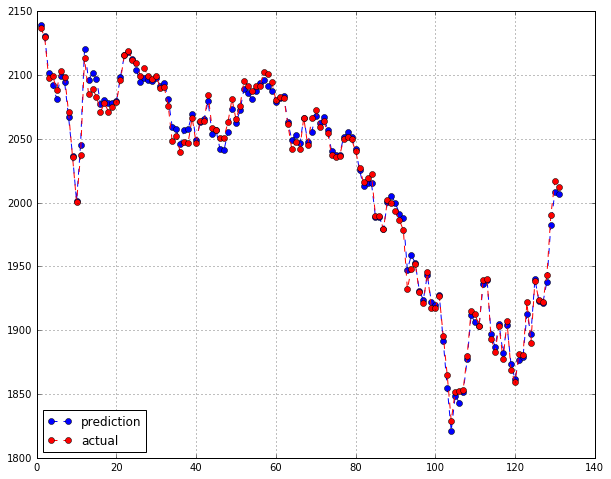

In [11]:
# Draw a plot to compare the true relationship to OLS predictions

from statsmodels.sandbox.regression.predstd import wls_prediction_std
prstd, iv_l, iv_u = wls_prediction_std(m_results)

fig, ax = plt.subplots(figsize=(10,8))
n = len(m_results.predict())
x = np.linspace(1, n, num=n, endpoint=True)
y_pred = m_results.predict()
y_true = sp500['Adj Close']

ax.grid(True)
ax.plot(x, y_pred, 'b--o', label="prediction", color='blue')
ax.plot(x, y_true, 'b--o', label="actual", color='red')
ax.legend(loc=3)

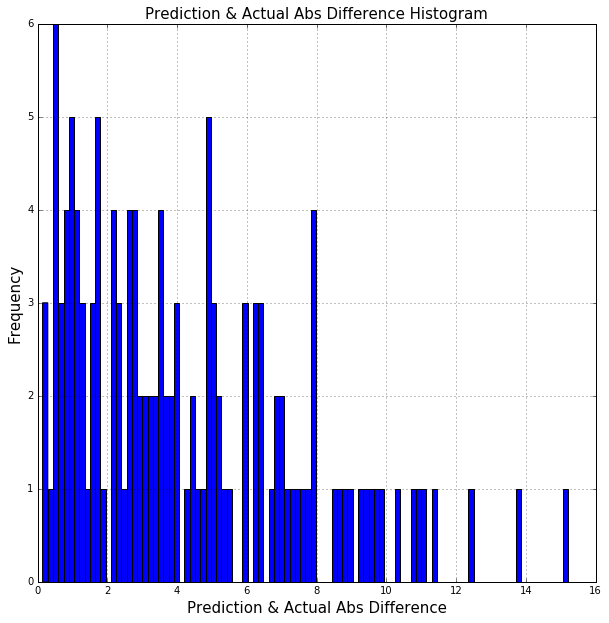

99 Percentile :  13.3476341025
95 Percentile :  10.5842526967
90 Percentile :  8.93604908931


In [12]:
# plot differences between predicated SP500 and actual SP500
%matplotlib inline
import matplotlib.pyplot as plt

diff = abs(y_pred - y_true)

fig = plt.figure(figsize=(10, 10))
plt.hist(diff, bins=100, color='blue')
plt.grid(True)
plt.title("Prediction & Actual Abs Difference Histogram", fontsize=15)
plt.xlabel("Prediction & Actual Abs Difference", fontsize=15)
plt.ylabel("Frequency", fontsize=15)
plt.show()

# 99%, 95%, 90% difference
print("99 Percentile : ", np.percentile(diff, 99))
print("95 Percentile : ", np.percentile(diff, 95))
print("90 Percentile : ", np.percentile(diff, 90))


**Observation:** 

1. This shows 99 percentile absolute difference between predicated SP500 and actual SP500 is less than 13.34
2. This shows 95 percentile absolute difference between predicated SP500 and actual SP500 is less than 10.58
3. This shows 90 percentile absolute difference between predicated SP500 and actual SP500 is less than 8.94

In [13]:
'''
# To check Multicollinearity, we check condition numbers from OLSResults
#
# The condition number measures the sensitivity of a function’s output to its input. 
# When two predictor variables are highly correlated, which is called multicolinearity, the coefficients 
# or factors of those predictor variables can fluctuate erratically for small changes in the data, or the model. 
# Ideally, similar models should be similar, i.e., have approximately equal coefficients. Multicolinearity can 
# cause numerical matrix inversion to crap out, or produce inaccurate results. One approach to this problem in
# regression is the technique of ridge regression, which is available in the sklearn Python module.
#
# We are looking for condition number as small as possible, ideally < 35

Further improvement: 

Here, we use the idea of 'Best Subsets' to find which dimensions should be 
involved to determine the best model in order to Multicollinearity. 

Now, we have 7 independents, after taking out real estate sector. Therefore,
we have total 2^7=128 subsets using 7 independents combinations. 

'''
from itertools import *
m_colTitles = set(['cust', 'idst', 'util', 'tech', 'fina', 'engy', 'care'])

# power set is the set of all possible subsets of a set
def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

# print condition number of OLS regression 
def printCondNum(x, y, x_name):
    print(x_name,': ',sm.OLS(y, x).fit().condition_number)    

for e in powerset(m_colTitles):
    if e: 
        printCondNum(m_data[list(e)], sp500, e)

('fina',) :  1.0
('tech',) :  1.0
('util',) :  1.0
('engy',) :  1.0
('idst',) :  1.0
('cust',) :  1.0
('care',) :  1.0
('fina', 'tech') :  94.7555089627
('fina', 'util') :  139.737696307
('fina', 'engy') :  31.8238949641
('fina', 'idst') :  146.296090409
('fina', 'cust') :  245.830435015
('fina', 'care') :  162.428078262
('tech', 'util') :  78.157229643
('tech', 'engy') :  51.891405788
('tech', 'idst') :  122.496964645
('tech', 'cust') :  181.487725712
('tech', 'care') :  81.3057628439
('util', 'engy') :  137.934241213
('util', 'idst') :  66.0978081326
('util', 'cust') :  78.7625508834
('util', 'care') :  59.830720208
('engy', 'idst') :  167.805482535
('engy', 'cust') :  134.372353739
('engy', 'care') :  231.971298366
('idst', 'cust') :  108.429051083
('idst', 'care') :  68.2879080212
('cust', 'care') :  62.5679873413
('fina', 'tech', 'util') :  233.960408026
('fina', 'tech', 'engy') :  102.956613729
('fina', 'tech', 'idst') :  243.695883536
('fina', 'tech', 'cust') :  263.231563574
('

Observation: 

1. If we pick two dimensions, the best combination of independents is ('engy', 'fina'), cond=31.82
2. If we pick three, the best combination of independents is ('util', 'care', 'idst'), cond=90.34
3. If we pick four, the best combination of independents is ('cust', 'util', 'care', 'idst'), cond=174.07
4. If we pick five, the best combination of independents is ('engy', 'tech', 'cust', 'util', 'care'), cond= 409.72
5. Let's try multiple regression of ('engy', 'fina') and ('util', 'care', 'idst'), whose cond < 100

In [14]:
# Multiple regression using ('engy', 'fina')
x = m_data[list(('engy', 'fina'))]
y = sp500
print(sm.OLS(y, x).fit().summary())

                            OLS Regression Results                            
Dep. Variable:              Adj Close   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 3.168e+05
Date:                Tue, 12 Jul 2016   Prob (F-statistic):          8.11e-239
Time:                        17:38:19   Log-Likelihood:                -626.21
No. Observations:                 131   AIC:                             1256.
Df Residuals:                     129   BIC:                             1262.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
engy          32.7003      2.293     14.263      0.0

In [15]:
# Multiple regression using ('util', 'care', 'idst')
x = m_data[list(('util', 'care', 'idst'))]
y = sp500
print(sm.OLS(y, x).fit().summary())

                            OLS Regression Results                            
Dep. Variable:              Adj Close   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.367e+05
Date:                Tue, 12 Jul 2016   Prob (F-statistic):          3.91e-224
Time:                        17:38:20   Log-Likelihood:                -654.21
No. Observations:                 131   AIC:                             1314.
Df Residuals:                     128   BIC:                             1323.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
util           0.4804      1.081      0.444      0.6

**Observation:** 

1. ('engy', 'fina') performs better than ('util', 'care', 'idst'), as for p-value
2. ('engy', 'fina') performs better than ('util', 'care', 'idst'), as for condition number

Conclusion:
======

1. There is a lot of pre work needed before we actually run multiple regression 

2. Pre work including: 
⋅⋅*  checking independents correlation matrix
⋅⋅*  independent scatter plots
⋅⋅*  independent vs dependent regression pair
⋅⋅*  residual analysis  

3. In this example, we use "Best Subsets" to find the best OLS model in order to minimize Multicollinearity and find most statistical significance 
